In [6]:
from pprint import pprint
import pandas as pd
import numpy as np
import cx_Oracle
import getpass
import datetime

usr = 'ephelps'
svr = 'hssc-cdwr3-dtdb-p.clemson.edu'
sid = 'dtprd2'
pwd = getpass.getpass('%s@%s/%s'%(usr,svr,sid))
connstr = '%s/%s@%s:1521/%s'%(usr,pwd,svr,sid)

def q(sql, connstr=connstr, asize=50000):
    sqlx = sql #' '.join(sql.split())
    conn = cx_Oracle.connect(connstr)
    print('connection opened')
    try:
        cur = conn.cursor()
        cur.arraysize = asize
        try:
            cur.execute(sqlx)
        except (cx_Oracle.DatabaseError) as e:
            error, = e.args
            print(error.code)
            print(error.message)
            print(error.context)
            print(sqlx)
            raise
        for rec in cur:
            yield rec
        cur.close()
    finally:
        conn.close()
        print('connection closed')

ephelps@hssc-cdwr3-dtdb-p.clemson.edu/dtprd2········


In [2]:
sql_death = '''
select /*+ parallel 4 */
        pat.deceased_ind,
        trunc(pat.death_date, 'month') death_month,
        count(distinct enc.patient_id) n_pats_w_encs_afdeath,
        count(distinct enc0.patient_id) n_pats_w_encs_b4birth,
        count(distinct pat.patient_id) n_pats
from cdw.patient pat
left outer join cdw.visit enc
        on (    pat.patient_id = enc.patient_id
            and trunc(enc.visit_start_date) > pat.death_date )
left outer join cdw.visit enc0
        on (    pat.patient_id = enc0.patient_id
            and enc0.visit_start_date < trunc(pat.birth_date) )
where pat.birth_date is not null
--  and (   trunc(enc.visit_start_date) > pat.death_date )
--  and (   enc0.visit_start_date < trunc(pat.birth_date) )
group by
        pat.deceased_ind,
        trunc(pat.death_date, 'month')
order by
        pat.deceased_ind,
        trunc(pat.death_date, 'month') desc
'''

sql_death_cnames = ['deceased', 'death_dt',
                    'n_encs_afdeath', 'n_encs_b4birth', 'n_pats']

In [3]:
%time pat_death_ts = q(sql_death)
%time pat_death_ts_df = pd.DataFrame(pat_death_ts, columns=sql_death_cnames)
pat_death_ts_df.to_csv('20170502_1900_death.psv', sep='|', index=False)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.01 µs
connection opened
connection closed
CPU times: user 16 ms, sys: 8 ms, total: 24 ms
Wall time: 38.9 s


In [2]:
pat_death_ts_df = pd.read_csv('20170502_1900_death.psv', sep='|')

In [3]:
pat_death_ts_df

deceased    death_dt  n_encs_afdeath  n_encs_b4birth   n_pats
0          N         NaN               0            2647  3985499
1          N  2017-04-01               1               0        7
2          N  2017-03-01               0               0        9
3          N  2017-02-01               0               0        7
4          N  2017-01-01               1               0       14
5          N  2016-12-01               2               0       16
6          N  2016-11-01               1               0       11
7          N  2016-10-01               4               0       14
8          N  2016-09-01               1               0       13
9          N  2016-08-01               3               0       24
10         N  2016-07-01               3               0       22
11         N  2016-06-01               5               0       30
12         N  2016-05-01               3               0       26
13         N  2016-04-01               4               0       20
14         N  2016-03-01               4               0       19
15         N  2016-02-01               2               0       23
16         N  2016-01-01               2               0       17
17         N  2015-12-01               2               0       20
18         N  2015-11-01               2               0       11
19         N  2015-10-01               1               0       12
20         N  2015-09-01               4               0       22
21         N  2015-08-01               8               0       20
22         N  2015-07-01               1               0        9
23         N  2015-06-01               1               0        7
24         N  2015-05-01               0               0        8
25         N  2015-04-01               0               0        6
26         N  2015-03-01               1               0       16
27         N  2015-02-01               1               0       11
28         N  2015-01-01               0               0        7
29         N  2014-12-01               2               0       13
..       ...         ...             ...             ...      ...
429        Y  1993-11-01               0               0        2
430        Y  1993-10-01               0               0        1
431        Y  1993-03-01               0               0        3
432        Y  1993-01-01               0               0        4
433        Y  1992-12-01               1               0        1
434        Y  1992-11-01               0               0        1
435        Y  1992-10-01               1               0        1
436        Y  1992-09-01               0               0        1
437        Y  1992-06-01               1               0        3
438        Y  1992-05-01               0               0        3
439        Y  1992-04-01               0               0        1
440        Y  1992-03-01               0               0        2
441        Y  1992-02-01               0               0        1
442        Y  1991-12-01               1               0        1
443        Y  1991-06-01               0               0        1
444        Y  1991-04-01               0               0        2
445        Y  1991-02-01               1               0        1
446        Y  1991-01-01               0               0        1
447        Y  1990-08-01               0               0        1
448        Y  1990-06-01               0               0        1
449        Y  1989-11-01               0               0        1
450        Y  1989-09-01               0               0        1
451        Y  1988-04-01               0               0        1
452        Y  1988-03-01               0               0        1
453        Y  1987-09-01               1               0        1
454        Y  1987-02-01               0               0        3
455        Y  1962-10-01               1               0        1
456        Y  1958-04-01               1               0        1
457        Y  1951-07-01               1    

In [1]:
import glob
import pandas as pd

cnames = '''VITAL_ID
FLOWSHEETID
SourceSystem
VISIT_ID
ACCOUNT_NUM
PATIENT_ID
ADMIT_DATE
OBSERVATION_DATE
OBSERVATION_ID
OBSERVATION_NAME
OBSERVATION_VALUE
UNITS
ObservationEvent
VitalSource
ModifierForObservation'''.split()

musc_vitals_df = pd.DataFrame()

for fn in glob.glob('/home/ephelps/Projects/hssc/test-data/musc_vitals/*.dat'):
    df = pd.read_csv(fn, sep='|', names=cnames, dtype=str, skiprows=1)
#     df['fn'] = fn
    musc_vitals_df = musc_vitals_df.append(df, ignore_index=True)
musc_vitals_df = musc_vitals_df.drop_duplicates()

In [2]:
df = musc_vitals_df.groupby('VITAL_ID').SourceSystem.agg(['count'])
print(len(df['count']), len(df[df['count']>1]))
len(df[df['count']>1])/(1.0*len(df['count']))

488081 5967


0.012225429795464277

In [4]:
# df[df['count']>1]
musc_vitals_df[musc_vitals_df.VITAL_ID=='1007980115-8172397-62']

Empty DataFrame
Columns: [VITAL_ID, FLOWSHEETID, SourceSystem, VISIT_ID, ACCOUNT_NUM, PATIENT_ID, ADMIT_DATE, OBSERVATION_DATE, OBSERVATION_ID, OBSERVATION_NAME, OBSERVATION_VALUE, UNITS, ObservationEvent, VitalSource, ModifierForObservation]
Index: []

In [5]:
# musc_vitals_df[musc_vitals_df.VITAL_ID=='1021732964-5757515-20'].fn.values
musc_vitals_df[musc_vitals_df.VITAL_ID=='1095627706']

Empty DataFrame
Columns: [VITAL_ID, FLOWSHEETID, SourceSystem, VISIT_ID, ACCOUNT_NUM, PATIENT_ID, ADMIT_DATE, OBSERVATION_DATE, OBSERVATION_ID, OBSERVATION_NAME, OBSERVATION_VALUE, UNITS, ObservationEvent, VitalSource, ModifierForObservation]
Index: []

In [5]:
musc_vitals_df.ADMIT_DATE.astype(str).str[0:6].value_counts()
# musc_vitals_df[musc_vitals_df.ADMIT_DATE.astype(str).str[0:6]=='201709']

201710    208368
201711    150775
201709    131300
201708      2330
201707       521
201706       432
201705       252
201704       147
201702        30
201611        22
201703         4
201508         1
201605         1
201409         1
201612         1
201610         1
Name: ADMIT_DATE, dtype: int64

In [7]:
sql_encs = '''
select
    patient_id,
    htb_enc_id_ext,
    htb_enc_act_id,
    htb_enc_act_ver_num
from cdw.visit
where visit_start_date > to_date('20140801', 'YYYYMMDD')
  and datasource_id in (1,25)
'''

sql_encs_cnames = ['cdw_patient_id', 'htb_enc_id_ext', 'htb_enc_act_id', 'htb_enc_ver_num']
%time enc_ids_df = pd.DataFrame(q(sql_encs), columns=sql_encs_cnames, dtype=str)

connection opened
connection closed
CPU times: user 23.9 s, sys: 2.86 s, total: 26.7 s
Wall time: 22min 25s


In [8]:
%time musc_vitals_df = musc_vitals_df.merge(enc_ids_df, how='left', left_on='VISIT_ID', right_on='htb_enc_id_ext')

CPU times: user 1.88 s, sys: 171 ms, total: 2.05 s
Wall time: 2.05 s


In [9]:
cnames = ['cdw_patient_id', 'htb_enc_act_id', 'htb_enc_ver_num',
          'OBSERVATION_ID', 'OBSERVATION_NAME',
          'OBSERVATION_DATE', 'OBSERVATION_VALUE']

musc_vitals_df_trimmed = musc_vitals_df[cnames]
musc_vitals_df_trimmed.loc[musc_vitals_df_trimmed.OBSERVATION_NAME=='WEIGHT/SCALE','OBSERVATION_VALUE'] = (musc_vitals_df_trimmed.loc[musc_vitals_df_trimmed.OBSERVATION_NAME=='WEIGHT/SCALE','OBSERVATION_VALUE'].astype(float)/16.0).values 

/home/ephelps/opt/anaconda3/envs/p3r6/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/ephelps/opt/anaconda3/envs/p3r6/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
w8s = musc_vitals_df_trimmed[musc_vitals_df_trimmed.OBSERVATION_NAME=='WEIGHT/SCALE'].dropna()
hts = musc_vitals_df_trimmed[musc_vitals_df_trimmed.OBSERVATION_NAME=='HEIGHT'].dropna()

/home/ephelps/opt/anaconda3/envs/p3r6/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


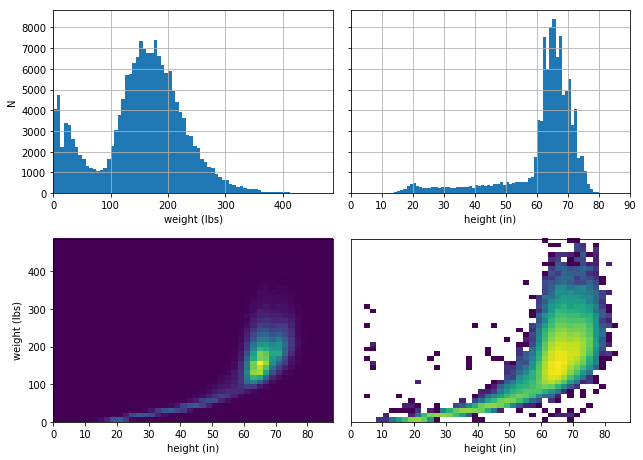

In [11]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

fig, _ = plt.subplots(2,2, sharey='row', figsize=(9,6.5))
axes = fig.axes

pd.to_numeric(w8s.OBSERVATION_VALUE).hist(bins=np.arange(0,8000/16.0,100/16.0), ax=axes[0])
axes[0].set_xlim(0,7800/16.0)
axes[0].set_xlabel('weight (lbs)')
axes[0].set_ylabel('N')
pd.to_numeric(hts.OBSERVATION_VALUE).hist(bins=np.arange(0,90,1), ax=axes[1])
axes[1].set_xlim(0,90)
axes[1].set_xlabel('height (in)')
w8s_hts = hts.merge(w8s, how='inner',
                    on=['OBSERVATION_DATE', 'cdw_patient_id',
                        'htb_enc_act_id', 'htb_enc_ver_num'],
                    suffixes=('_ht', '_w8')).dropna()
plt.subplot(2,2,4)
plt.xlabel('height (in)')
plt.hist2d(w8s_hts.OBSERVATION_VALUE_ht.astype(float).values,
           w8s_hts.OBSERVATION_VALUE_w8.astype(float).values,
           bins=(np.arange(0,90,2), np.arange(0,8000/16.0,200/16.0)),
           norm=mpl.colors.LogNorm())
plt.ylim(0,7800/16.0)
plt.yticks([])
plt.subplot(2,2,3)
plt.ylabel('weight (lbs)')
plt.xlabel('height (in)')
plt.hist2d(w8s_hts.OBSERVATION_VALUE_ht.astype(float).values,
           w8s_hts.OBSERVATION_VALUE_w8.astype(float).values,
           bins=(np.arange(0,90,2), np.arange(0,8000/16.0,200/16.0)))
plt.ylim(0,7800/16.0)
plt.tight_layout()
plt.show()

In [12]:
musc_vitals_df_trimmed.loc[:,'cdw_patient_id'] = musc_vitals_df_trimmed.cdw_patient_id.map(lambda x: int(x) if not np.isnan(x) else 'NULL').values
musc_vitals_df_trimmed.dropna().to_csv('musc_vitals_trimmed_20171204.csv', index=False)

/home/ephelps/opt/anaconda3/envs/p3r6/lib/python3.6/site-packages/pandas/core/indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
